In [2]:
!pip install facenet-pytorch
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.8 MB/s eta 0:00:00


In [3]:
# Import Libraries
import torch
import random
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from shutil import copy2
from google.colab import drive
from facenet_pytorch import MTCNN, InceptionResnetV1

#Mount Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
project_path = '/content/drive/MyDrive/Clustering Faces'

In [5]:
# Set the path to your dataset
data_dir = os.path.join(project_path, 'lfw')

# Get a list of all folder names in your dataset
folder_names = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

# Shuffle the list of folder names and select the first 2000
random.shuffle(folder_names)
selected_folders = folder_names[:400]

# Get a list of all image paths in your selected folders
image_paths = []
for folder_name in selected_folders:
    folder_path = os.path.join(data_dir, folder_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        if image_path.endswith('.jpg') or image_path.endswith('.png'):  # add more image extensions if needed
            image_paths.append(image_path)


In [6]:
def load_and_align_data(image_paths, image_size, margin):
    # Initialize the MTCNN face detector with the specified image size and margin
    mtcnn = MTCNN(image_size=image_size, margin=margin)

    # Create an empty list to store the aligned images
    img_list = []

    # Loop over the image paths
    for image_path in image_paths:
        # Open the image file
        img = Image.open(image_path)

        # Use the MTCNN face detector to detect and align faces in the image
        img_cropped = mtcnn(img)

        # Add the cropped image to the list of aligned images
        img_list.append(img_cropped)

    # Stack the list of images into a single PyTorch tensor
    images = torch.stack(img_list)

    # Return the tensor of aligned images
    return images


In [7]:
image_size = 160
margin = 44
images = load_and_align_data(image_paths, image_size, margin)

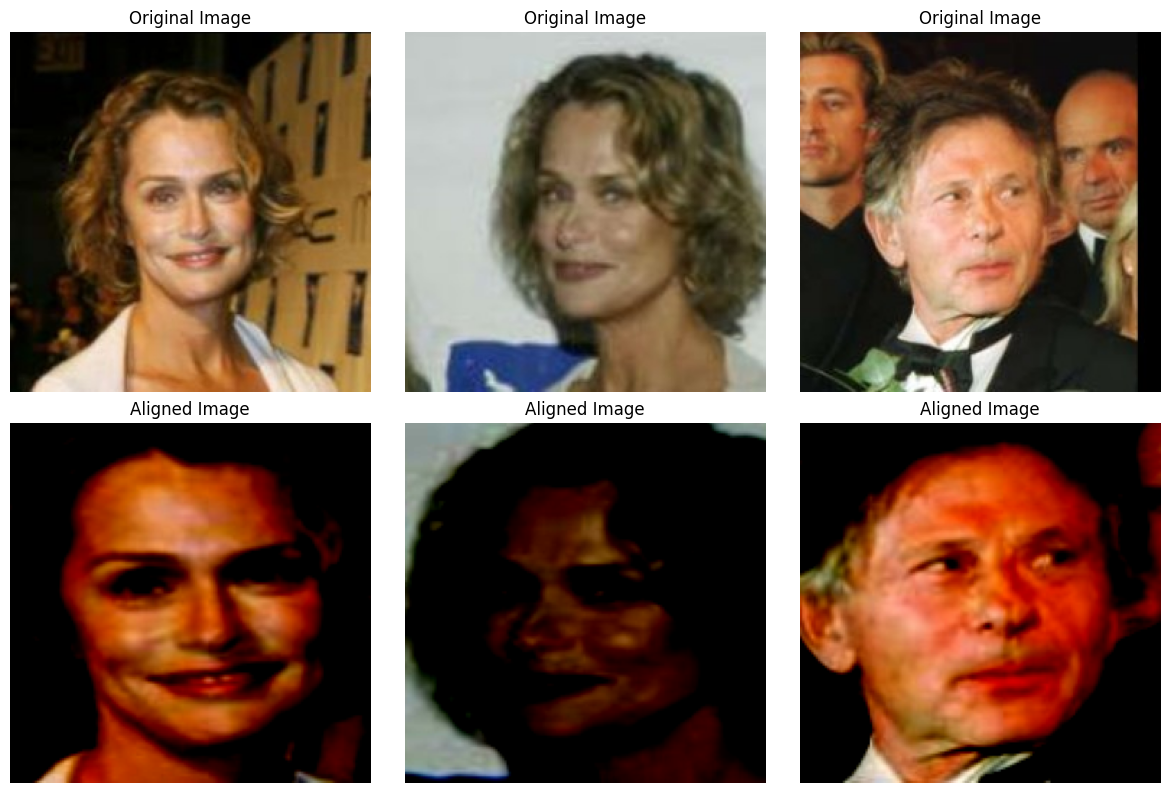

In [8]:
"""
Plot the original images and their corresponding aligned image
"""

# Assuming you have a list of image paths named image_paths
original_images = image_paths[0:3]

# Assuming you have a list of image paths named original_images
# Assuming you have a list of torch images named images

# Plot the first 3 original images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(3):
    # Load the original image using PIL
    original_image = Image.open(original_images[i])

    # Plot the original image
    axes[0, i].imshow(original_image)
    axes[0, i].axis('off')
    axes[0, i].set_title('Original Image')

    # Plot the torch image
    axes[1, i].imshow(images[i].permute(1, 2, 0))
    axes[1, i].axis('off')
    axes[1, i].set_title('Aligned Image')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [6]:
def generate_embeddings(image_paths, image_size, margin):
    """
    Generate embeddings for a list of images.

    This function uses the InceptionResnetV1 model, pretrained on the VGGFace2 dataset, to generate embeddings for each image.
    The images are first loaded and aligned using the MTCNN model.

    Parameters:
    image_paths (list): List of paths to the images for which to generate embeddings.
    image_size (int): The size to which to resize the images before generating embeddings.
    margin (int): The margin to use when aligning the images with MTCNN.

    Returns:
    embeddings (torch.Tensor): A tensor containing the embeddings for the images.
    """
    # Load and align the images
    images = load_and_align_data(image_paths, image_size, margin)

    # Create an InceptionResnetV1 model pretrained on the VGGFace2 dataset
    resnet = InceptionResnetV1(pretrained='vggface2').eval()

    # Generate embeddings for the images
    embeddings = resnet(images)

    return embeddings



In [7]:
def calculate_distance_matrix(embeddings):
    # Get the number of images (faces)
    nrof_images = len(embeddings)

    # Initialize a zero matrix of size nrof_images x nrof_images
    matrix = np.zeros((nrof_images, nrof_images))

    # Loop over each pair of images
    for i in range(nrof_images):
        for j in range(nrof_images):

            # Calculate the Euclidean distance between the embeddings of the two images
            # First, subtract the embeddings of the two images element-wise
            # Then, square the result
            # Sum all the elements
            # Take the square root of the sum to get the Euclidean distance
            dist = np.sqrt(np.sum(np.square(np.subtract(embeddings[i, :].detach().numpy(), embeddings[j, :].detach().numpy()))))

            # Store the distance in the matrix
            matrix[i][j] = dist

    # Return the distance matrix
    return matrix

In [8]:
def sort_faces(names, matrix):
    # Initialize an empty list to store the sorted faces
    sorted_faces = []

    # Start with the first face in the list
    face = names[0]
    sorted_faces.append(face)

    # For each face in the list, except for the first one
    for i in range(len(names)-1):
        # Get the distances of the current face to all other faces
        closest_faces = matrix[i, :]

        # Remove the distance to itself (which is zero)
        closest_faces = closest_faces[closest_faces != 0]

        # Get the indices that would sort the array of distances
        closest_faces_indices = np.argsort(closest_faces)

        # The first index is the one that gives the smallest distance
        closest_face_index = closest_faces_indices[0]

        # Get the name of the face with the smallest distance
        similar_face = names[closest_face_index]

        # Add the face with the smallest distance to the sorted list
        sorted_faces.append(similar_face)

        # Update the current face to the face with the smallest distance
        face = similar_face

    # Return the sorted list of faces
    return sorted_faces


In [15]:
def cluster_faces(names, embeddings, n_clusters=8):
    # Initialize KMeans with desired number of clusters, a fixed random state for reproducibility, and a large number of iterations
    kmeans = KMeans(n_clusters=n_clusters, random_state=40, max_iter=100000)

    # Fit the KMeans model to the embeddings and predict the cluster labels for each embedding
    labels_kmeans = kmeans.fit_predict(embeddings.detach().numpy())

    # # For each image
    # for i in range(len(labels_kmeans)):
    #     # Construct the path to the folder for the cluster that the image belongs to
    #     folder_for_clust = os.path.join(project_path, 'data/clustered/', str(labels_kmeans[i]))

    #     # If the folder does not exist, create it
    #     if not os.path.exists(folder_for_clust):
    #         os.makedirs(folder_for_clust)

    #     # Get the path to the image
    #     file = names[i]

    #     # Copy the image to the appropriate cluster folder
    #     copy2(file, folder_for_clust)

    # Return the cluster labels
    return labels_kmeans


In [ ]:
image_size = 160  # This is the size of the images that will be used for generating embeddings. It's set to 160 because that's the input size expected by the FaceNet model.

margin = 44  # This is the margin for the crop around the bounding box when aligning the images. The MTCNN model uses a margin of 44 by default.

embeddings = generate_embeddings(image_paths, image_size, margin)  # This function generates embeddings for the images using the FaceNet model. The embeddings are 512-dimensional vectors that represent the faces in the images.

matrix = calculate_distance_matrix(embeddings)  # This function calculates the Euclidean distance matrix for the embeddings. Each entry in the matrix represents the distance between two faces.

sorted_faces = sort_faces(image_paths, matrix)  # This function sorts the faces based on their distance to each other. The sorted list of faces is used to arrange the images in a visually pleasing way.

In [ ]:
labels_kmeans = cluster_faces(image_paths, embeddings)  # This function clusters the faces using the KMeans algorithm. The labels for each face (i.e., which cluster it belongs to) are returned.

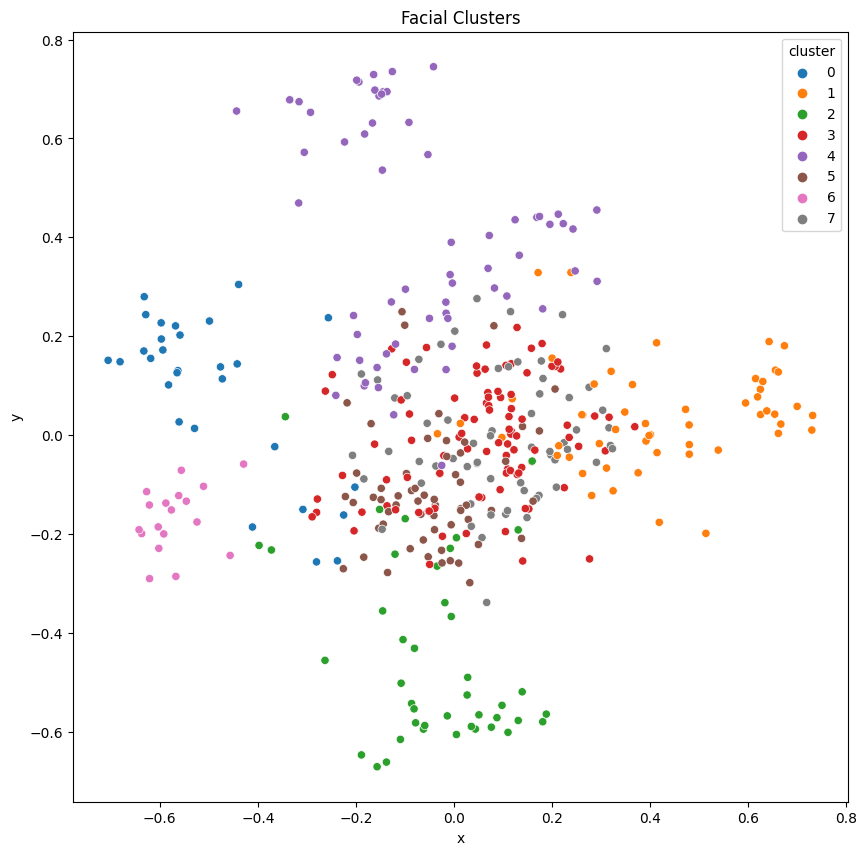

In [17]:
# Import necessary libraries for PCA and visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Create a PCA object that will reduce the dimensionality to 2
pca = PCA(n_components=2)

# Fit the PCA model to the embeddings and transform the embeddings to 2D
embeddings_2d = pca.fit_transform(embeddings.detach().numpy())

# Create a DataFrame that includes the 2D embeddings and their corresponding cluster labels
df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df['cluster'] = labels_kmeans

# Create a new figure with a specified size
plt.figure(figsize=(10, 10))

# Create a scatter plot of the 2D embeddings, using the cluster labels to color the points
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='tab10')

# Set the title of the plot
plt.title('Facial Clusters')

# Display the plot
plt.show()


In [35]:
def plot_cluster_images(cluster_labels, image_paths, max_images_per_cluster=10):
    # Get unique cluster labels
    unique_labels = np.unique(cluster_labels)

    # For each unique label
    for label in unique_labels:
        # Create a new figure with a subplot for each image in the cluster (up to max_images_per_cluster)
        fig, ax = plt.subplots(1, max_images_per_cluster, figsize=(20, 2))

        # Get the image paths for images in the current cluster
        cluster_image_paths = [path for path, cluster_label in zip(image_paths, cluster_labels) if cluster_label == label]

        # For each image path in the cluster
        for i, image_path in enumerate(cluster_image_paths[:max_images_per_cluster]):
            # Open the image
            image = Image.open(image_path)

            # Display the image in the corresponding subplot
            ax[i].imshow(image)

            # Turn off the axis
            ax[i].axis('off')

            # Add the image name as the title of the subplot
            ax[i].set_title(os.path.basename(image_path), fontsize=7)

        # Set the title for the figure
        fig.suptitle(f'Cluster {label}', fontsize=12)

        # Add a grid to the figure
        plt.grid(True)

        # Display the figure
        plt.show()


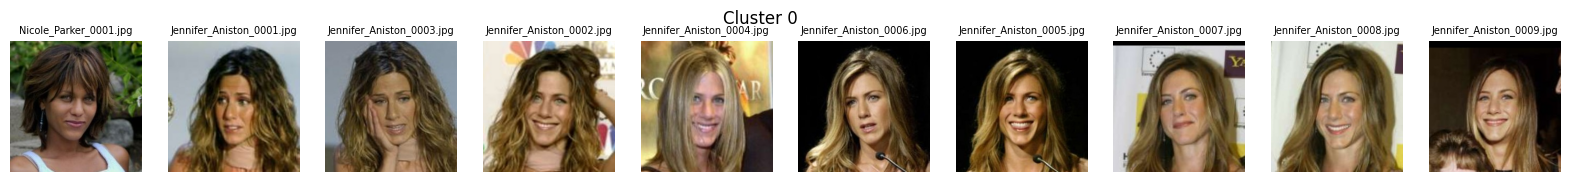

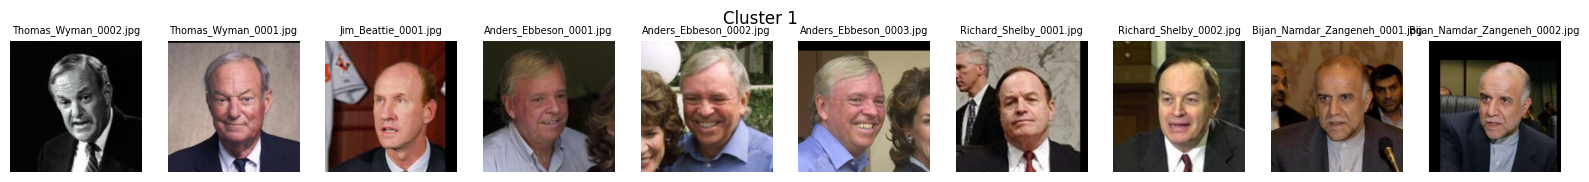

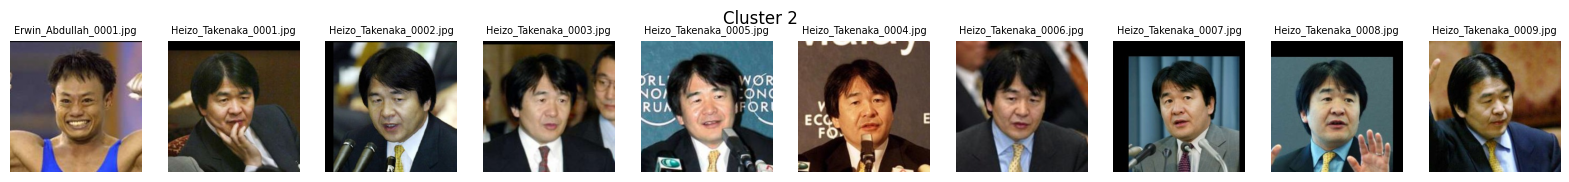

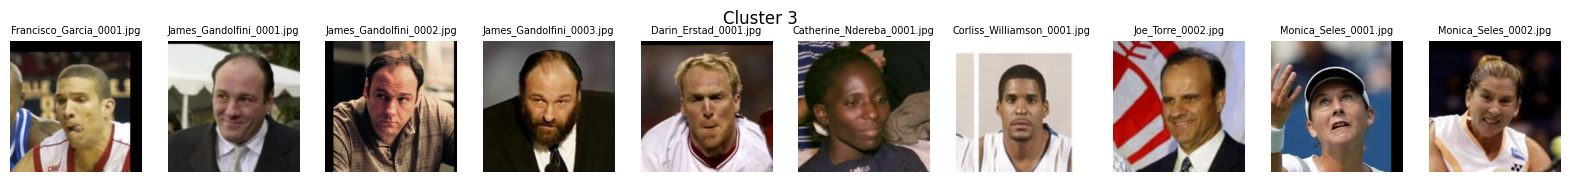

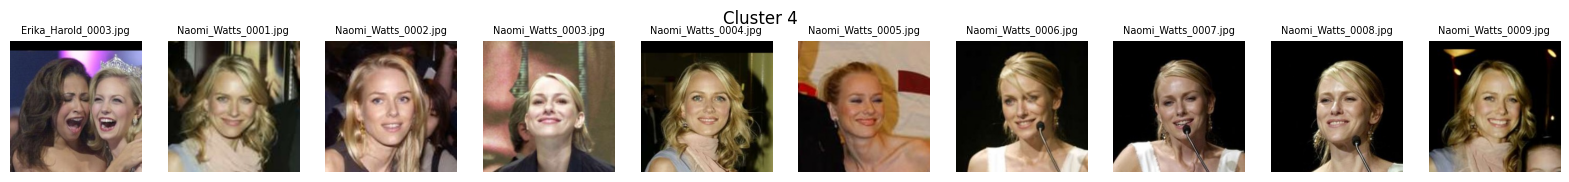

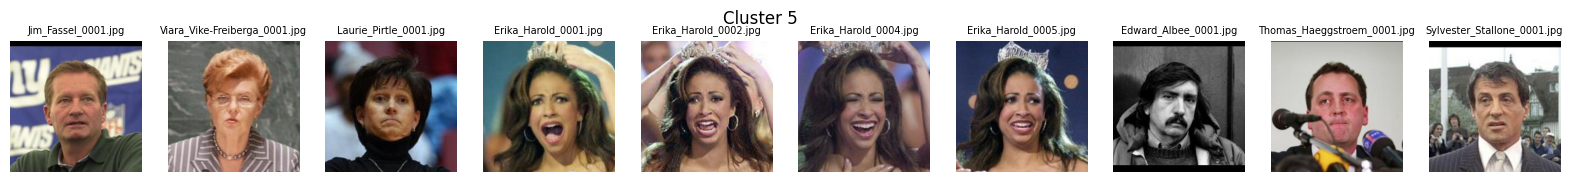

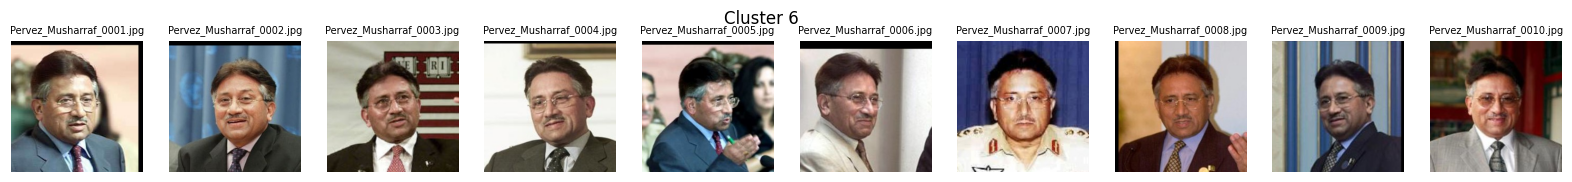

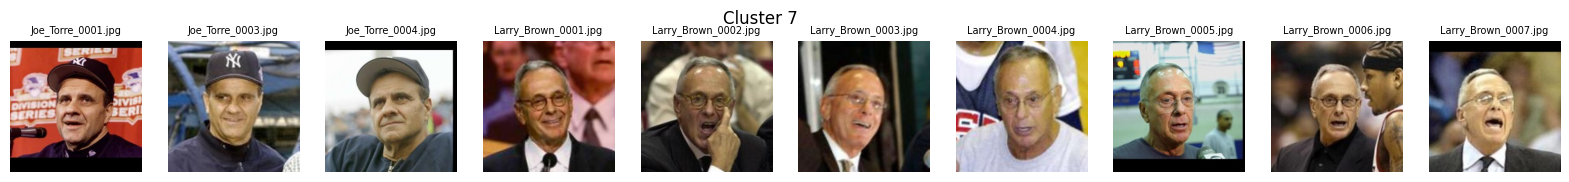

In [36]:
plot_cluster_images(labels_kmeans, image_paths)

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


In [87]:
def cluster_faces_dbscan(embeddings, eps=0.55, min_samples=4):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_dbscan = dbscan.fit_predict(embeddings)
    labels_dbscan = labels_dbscan + 2  # Add 1 to the labels to start from 0
    return labels_dbscan

labels_dbscan = cluster_faces_dbscan((embeddings.detach().numpy()))

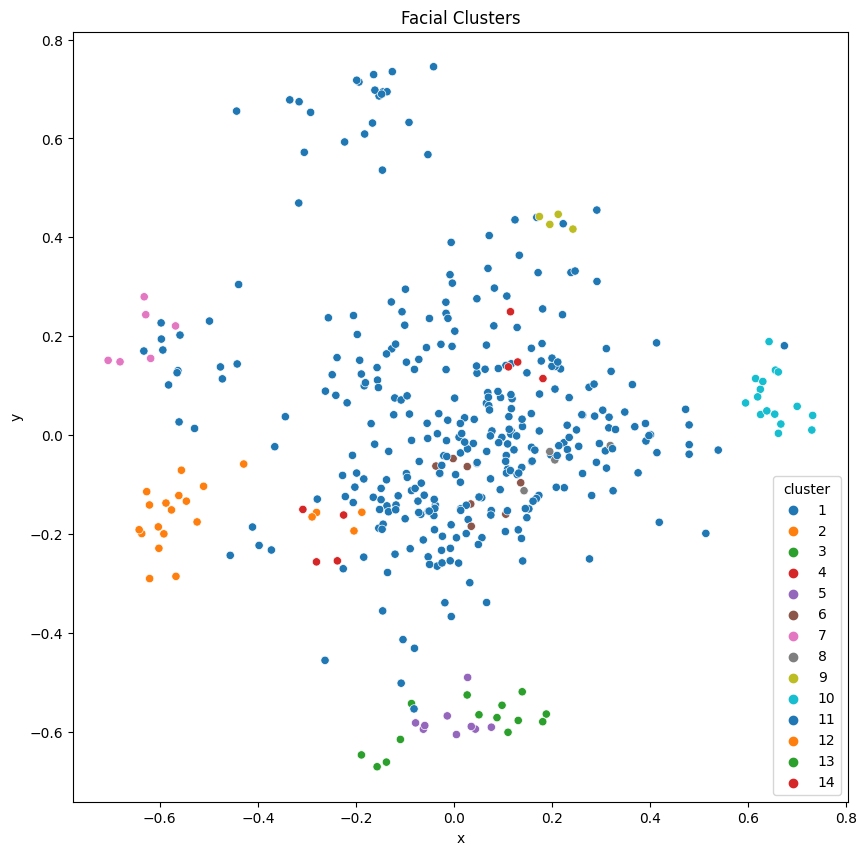

In [90]:
# Import necessary libraries for PCA and visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Create a PCA object that will reduce the dimensionality to 2
pca = PCA(n_components=2)

# Fit the PCA model to the embeddings and transform the embeddings to 2D
embeddings_2d = pca.fit_transform(embeddings.detach().numpy())

# Create a DataFrame that includes the 2D embeddings and their corresponding cluster labels
df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df['cluster'] = labels_dbscan

# Create a new figure with a specified size
plt.figure(figsize=(10, 10))

# Create a scatter plot of the 2D embeddings, using the cluster labels to color the points
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='tab10')

# Set the title of the plot
plt.title('Facial Clusters')

# Display the plot
plt.show()


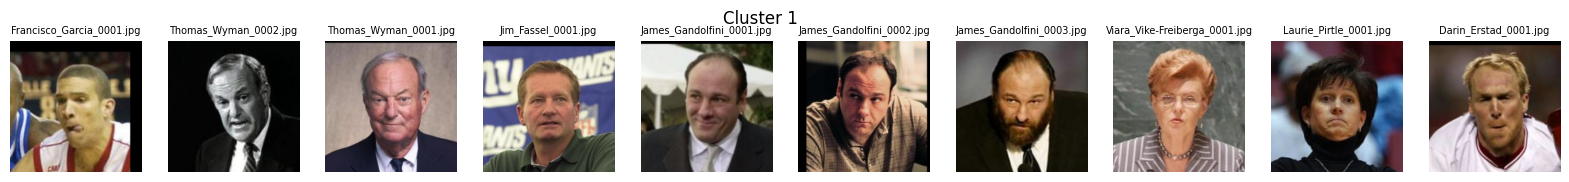

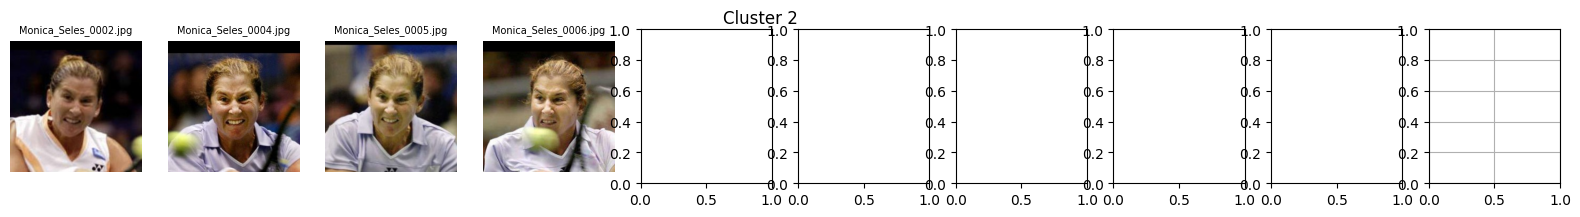

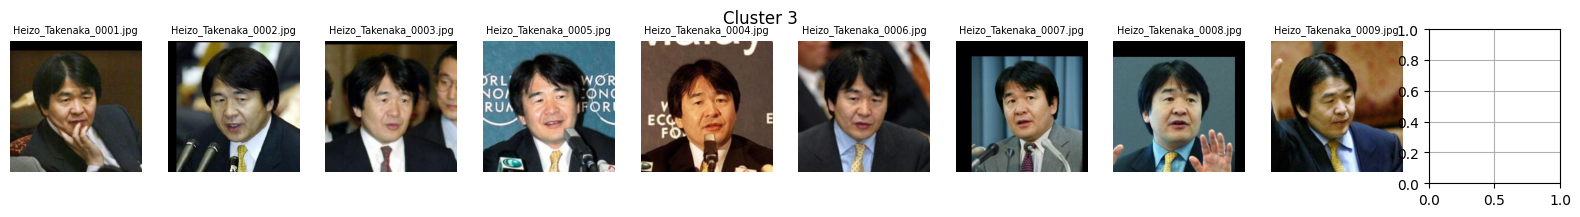

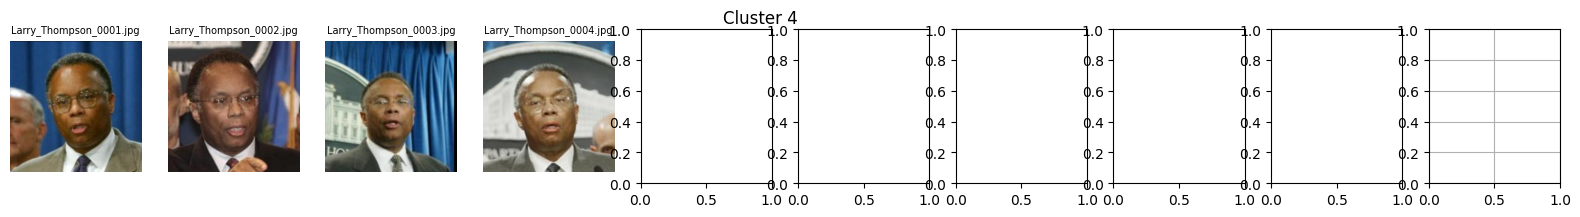

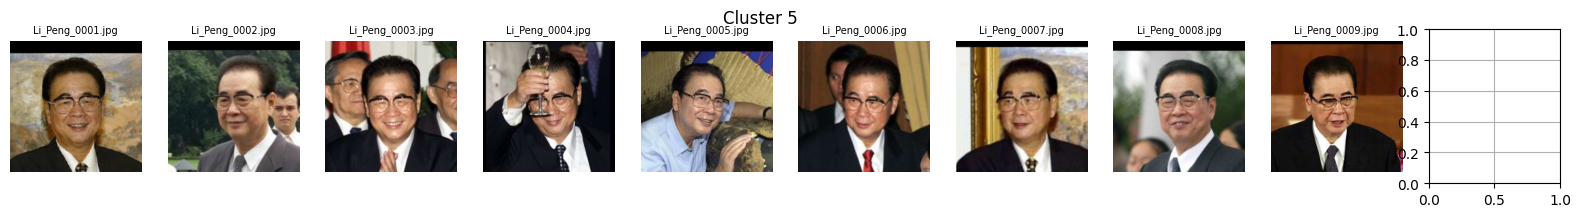

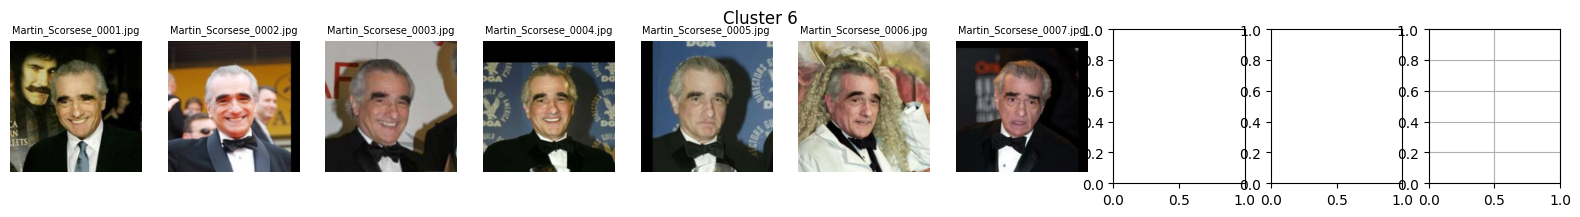

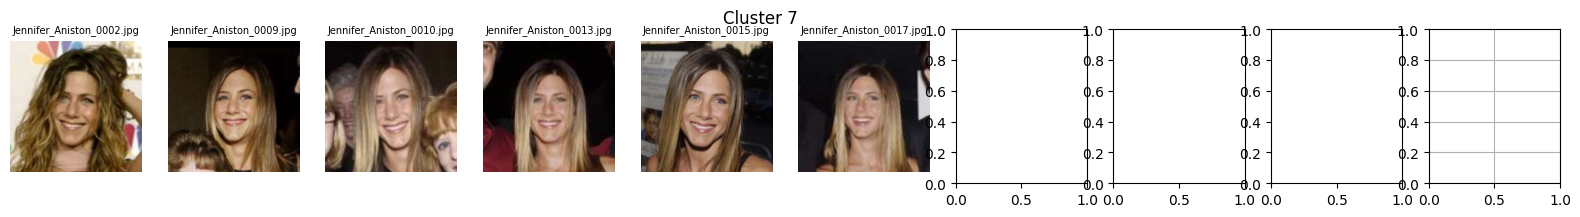

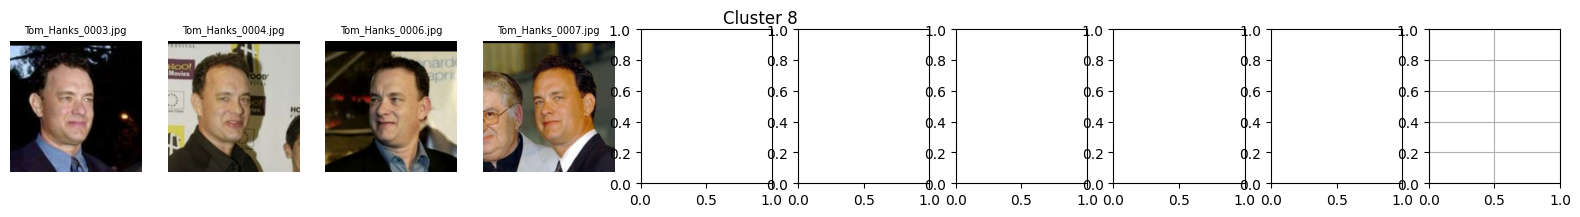

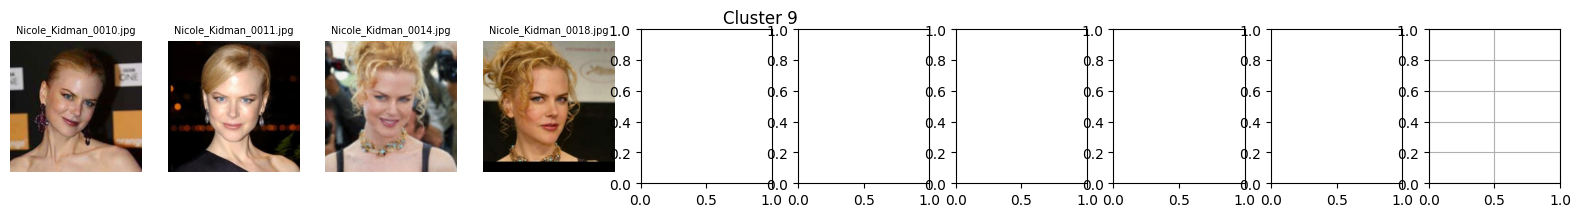

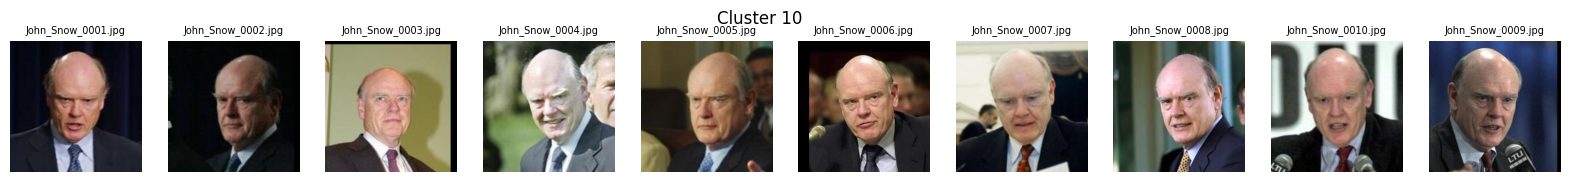

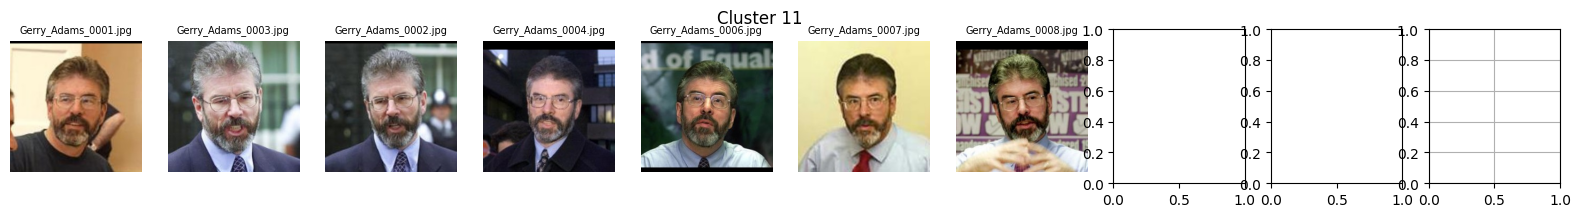

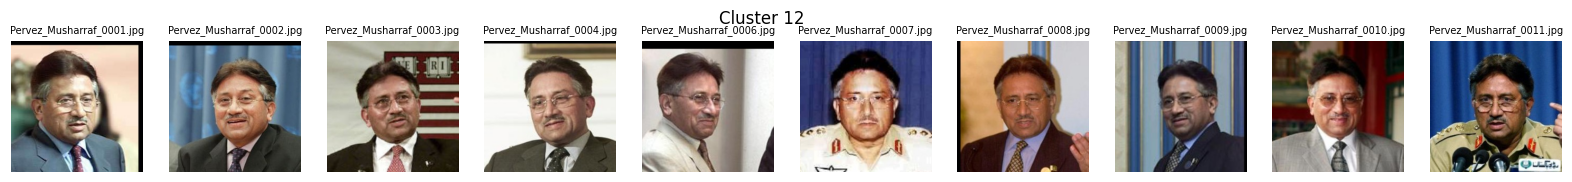

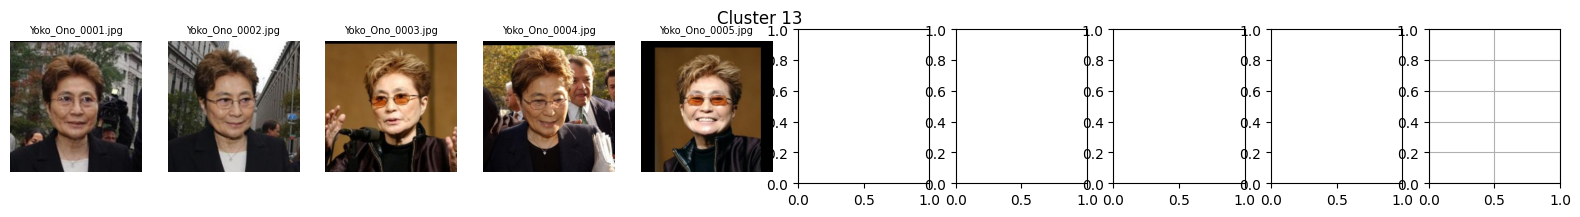

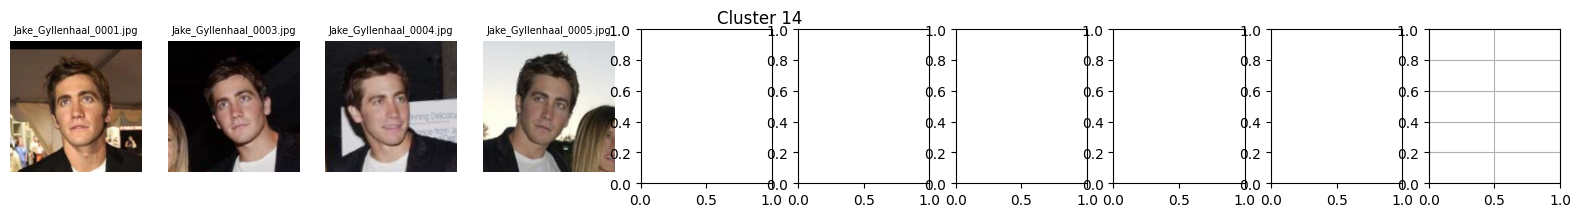

In [91]:
plot_cluster_images(labels_dbscan, image_paths)